In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import re
import missingno as mso
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import pandas as pd
import numpy as np
import joblib

In [2]:
data=pd.read_csv("seattle-weather.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [3]:
data.shape

(1461, 6)

In [4]:
countrain=len(data[data.weather=="rain"])
countsun=len(data[data.weather=="sun"])
countdrizzle=len(data[data.weather=="drizzle"])
countsnow=len(data[data.weather=="snow"])
countfog=len(data[data.weather=="fog"])
print("Percent of Rain:{:2f}%".format((countrain/(len(data.weather))*100)))
print("Percent of Sun:{:2f}%".format((countsun/(len(data.weather))*100)))
print("Percent of Drizzle:{:2f}%".format((countdrizzle/(len(data.weather))*100)))
print("Percent of Snow:{:2f}%".format((countsnow/(len(data.weather))*100)))
print("Percent of Fog:{:2f}%".format((countfog/(len(data.weather))*100)))

Percent of Rain:43.874059%
Percent of Sun:43.805613%
Percent of Drizzle:3.627652%
Percent of Snow:1.779603%
Percent of Fog:6.913073%


From the Above countplot the data set contains higher amount of data with the weather datail of ***Rain and Sun*** and it also have some additionals like ***drizzle,snow and fog*** .

In [5]:
data[["precipitation","temp_max","temp_min","wind"]].describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


From the above box plot between the ***Weather and Precipitation*** 
the value ***Rain*** has many **positive outliers** and both **Rain and Snow** were ***positively skewed/has positive skewness***.

As from the above result of ***T test and P value of 0*** indicates that the ***Null hypothesis*** in the corresponding columns is **rejected** and the columns are ***Statistically significant*** 

In [6]:
data.isna().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [7]:
df=data.drop(["date"],axis=1)

**Remove Outliers & Infinite Values**

Since this dataset contains ***Outliers ,it will be removed***,to make data set more even.

In [8]:
from scipy.stats import zscore

# Assuming df is your DataFrame
# Selecting the columns you want to check for outliers (excluding "weather" column)
columns_to_check = df.columns[df.columns != "weather"]

# Calculating z-scores for selected columns
z_scores = zscore(df[columns_to_check])

# Setting a threshold for z-score to identify outliers (e.g., z-score greater than 3)
threshold = 3

# Finding rows where any z-score exceeds the threshold
outlier_indices = (z_scores > threshold).any(axis=1)

# Filtering out rows containing outliers
df = df[~outlier_indices]


In [9]:
df.precipitation=np.sqrt(df.precipitation)
df.wind=np.sqrt(df.wind)

C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: xlabel='wind', ylabel='Count'>

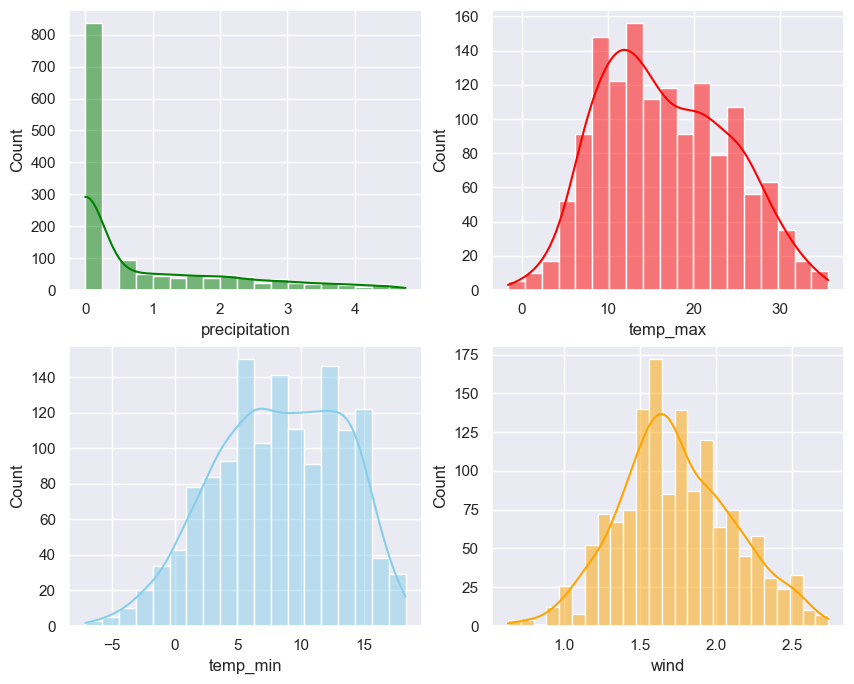

In [10]:
sns.set(style="darkgrid")
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.histplot(data=df,x="precipitation",kde=True,ax=axs[0,0],color='green')
sns.histplot(data=df,x="temp_max",kde=True,ax=axs[0,1],color='red')
sns.histplot(data=df,x="temp_min",kde=True,ax=axs[1,0],color='skyblue')
sns.histplot(data=df,x="wind",kde=True,ax=axs[1,1],color='orange')

In [11]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,drizzle
1,3.301515,10.6,2.8,2.121320,rain
2,0.894427,11.7,7.2,1.516575,rain
3,4.505552,12.2,5.6,2.167948,rain
4,1.140175,8.9,2.8,2.469818,rain


In [12]:
lc=LabelEncoder()
df["weather"]=lc.fit_transform(df["weather"])

In [13]:
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.000000,12.8,5.0,2.167948,0
1,3.301515,10.6,2.8,2.121320,2
2,0.894427,11.7,7.2,1.516575,2
3,4.505552,12.2,5.6,2.167948,2
4,1.140175,8.9,2.8,2.469818,2


In [14]:
from sklearn.preprocessing import StandardScaler
columns_to_scale = df.columns[df.columns != "weather"]
scaler = StandardScaler()
df = df.copy()  # Make a copy of the original DataFrame to preserve it
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df


,precipitation,temp_max,temp_min,wind,weather
0,-0.670153,-0.511060,-0.646187,1.152496,0
1,2.001130,-0.808255,-1.081040,1.028023,2
2,0.053536,-0.659658,-0.211333,-0.586336,2
3,2.975326,-0.592113,-0.527590,1.152496,2
4,0.252372,-1.037907,-1.081040,1.958333,2
...,...,...,...,...,...
1456,1.702618,-1.645807,-1.298467,-0.088841,2
1457,0.320798,-1.564754,-1.298467,-1.591130,2
1458,-0.670153,-1.267558,-1.515894,-0.330395,1
1459,-0.670153,-1.483700,-1.832151,0.287477,4


In [15]:
x=((df.loc[:,df.columns!="weather"]).astype(int)).values[:,0:]
y=df["weather"].values

In [16]:
df.weather.unique()

array([0, 2, 4, 3, 1])

In [17]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=2)

In [18]:
knn=KNeighborsClassifier()
knn.fit(x_train,y_train)
print("KNN Accuracy:{:.2f}%".format(knn.score(x_test,y_test)*100))

KNN Accuracy:61.97%


In [19]:
svm=SVC()
svm.fit(x_train,y_train)
print("SVM Accuracy:{:.2f}%".format(svm.score(x_test,y_test)*100))

SVM Accuracy:69.01%


In [20]:
gbc=GradientBoostingClassifier(subsample=0.5,n_estimators=450,max_depth=5,max_leaf_nodes=25)
gbc.fit(x_train,y_train)
print("Gradient Boosting Accuracy:{:.2f}%".format(gbc.score(x_test,y_test)*100))

Gradient Boosting Accuracy:67.61%


In [21]:
import warnings
warnings.filterwarnings('ignore')
xgb=XGBClassifier()
xgb.fit(x_train,y_train)
print("XGB Accuracy:{:.2f}%".format(xgb.score(x_test,y_test)*100))

XGB Accuracy:69.01%


In [22]:
input=[[1.140175,8.9,2.8,2.469818]]
ot=xgb.predict(input)
print("The weather is:")
if(ot==0):
    print("Drizzle")
elif(ot==1):
    print("Fog")
elif(ot==2):
    print("Rain")
elif(ot==3):
    print("snow")
else:
    print("Sun")

The weather is:
Rain


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X = df.drop(columns=["weather"])  # Assuming "weather" is the target column
y = df["weather"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7632508833922261


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

X = df.drop(columns=["weather"])  # Assuming "weather" is the target column
y = df["weather"]

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a Random Forest Classifier
clf = RandomForestClassifier()

# Training the classifier on the training data
clf.fit(X_train, y_train)

# Making predictions on the test data
y_pred = clf.predict(X_test)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.823321554770318


In [25]:
joblib.dump(clf, "your_model.pkl")

['your_model.pkl']